In [46]:
from composer.utils.object_store import ObjectStoreProviderHparams
from lth_diet.exps import TrainExperiment
from lth_diet.utils import utils
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
from tqdm import tqdm
plt.style.use("default")
rc = {
    "axes.grid": True, "axes.labelpad": 2, "axes.linewidth": 0.8, "axes.spines.right": False, "axes.spines.top": False, 
    "axes.titlepad": 2, "axes.titlesize": "medium", 
    "figure.constrained_layout.use": True, "figure.dpi": 150, "figure.figsize": (4, 3), "figure.titlesize": "medium", 
    "grid.linewidth": 0.8, 'legend.fontsize': "small", #  "legend.frameon": False,
    "xtick.major.pad": 2, "xtick.major.size": 3.5, "xtick.major.width": 0.8, 
    "ytick.major.pad": 2, "ytick.major.size": 3.5, "ytick.major.width": 0.8
}
sns.set_theme(style="ticks", palette=sns.color_palette("colorblind"), rc=rc)
object_store = ObjectStoreProviderHparams('google_storage', 'prunes', 'GCS_KEY').initialize_object()
bucket_dir = os.environ['OBJECT_STORE_DIR']

In [3]:
def get_accuracy_val(exp, num_reps, object_store):
    exp_hash = utils.get_hash(exp.name)
    steps_rt, accs_rt = [], []
    for rep in range(num_reps):
        object_store.download_object(f"{bucket_dir}/{exp_hash}/replicate_{rep}/main/log.txt", "temp.txt")
        log = pd.read_table("temp.txt", header=None)[0]
        os.remove("temp.txt")
        steps_t, accs_t = [], []
        for line in log:
            match = re.search('\[EPOCH\]\[step=(\d*)\]: { "accuracy/val": ([+-]?[0-9]*[.]?[0-9]+), \}', line)
            if match:
                steps_t.append(int(match.group(1)))
                accs_t.append(float(match.group(2)))
        steps_rt.append(steps_t)
        accs_rt.append(accs_t)
    steps_rt, accs_rt = np.array(steps_rt), np.array(accs_rt)
    return steps_rt, accs_rt

In [4]:
config = f"../configs/lr_data_warm_cf10_rn20/bs128.yaml"
num_replicates = 4
exp = TrainExperiment.create(f=config, cli_args=False)
lrs_bs128 = [0.1, 0.2, 0.4, 0.8, 1.6]
accs_bs128 = []
for lr in tqdm(lrs_bs128):
    exp.optimizer.lr = lr
    _, accs_rt = get_accuracy_val(exp, num_replicates, object_store)
    accs_bs128.append(accs_rt[:, -1])
accs_bs128 = np.array(accs_bs128).T

100%|██████████| 5/5 [00:16<00:00,  3.35s/it]


In [5]:
config = f"../configs/lr_data_warm_cf10_rn20/bs1024.yaml"
num_replicates = 4
exp = TrainExperiment.create(f=config, cli_args=False)
lrs_bs1024 = [0.2, 0.4, 0.8, 1.6, 3.2]
accs_bs1024 = []
for lr in tqdm(lrs_bs1024):
    exp.optimizer.lr = lr
    _, accs_rt = get_accuracy_val(exp, num_replicates, object_store)
    accs_bs1024.append(accs_rt[:, -1])
accs_bs1024 = np.array(accs_bs1024).T

100%|██████████| 5/5 [00:09<00:00,  1.82s/it]


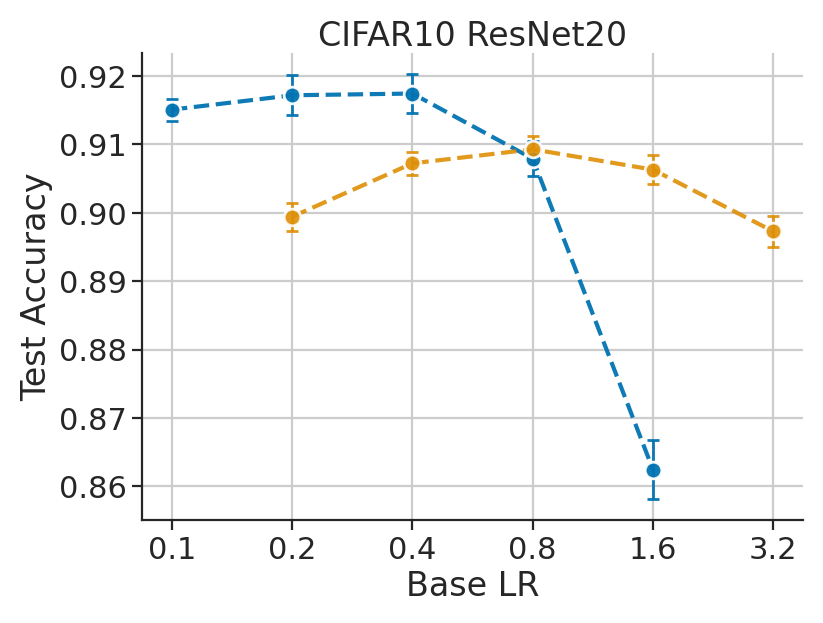

In [6]:
fig, axes = plt.subplots(dpi=200)
ls = []
ax = axes
x, ys = np.array(lrs_bs128), accs_bs128
ym, ye = ys.mean(0), ys.std(0)
l = ax.errorbar(np.log2(x*10), ym, yerr=ye, marker="o", elinewidth=1, ls='--', capsize=2, mec="white", alpha=0.95)
ls.append(l)
x, ys = np.array(lrs_bs1024), accs_bs1024
ym, ye = ys.mean(0), ys.std(0)
l = ax.errorbar(np.log2(x*10), ym, yerr=ye, marker="o", elinewidth=1, ls='--', capsize=2, mec="white", alpha=0.9)
ls.append(l)
plt.xticks([0, 1, 2, 3, 4, 5], [0.1, 0.2, 0.4, 0.8, 1.6, 3.2])
# plt.ylim(0.9, 0.92)
plt.xlabel("Base LR")
plt.ylabel("Test Accuracy")
plt.title("CIFAR10 ResNet20")
plt.show()

In [37]:
config = f"../configs/lr_data_warm_cf10_rn20/bs1024_warmup.yaml"
num_replicates = 4
exp = TrainExperiment.create(f=config, cli_args=False)
lrs_bs1024 = [0.2, 0.4, 0.8, 1.6, 3.2]
warmups = [100, 200, 400, 800, 1600]
accs_wl = []
for warmup in warmups:
    accs_l = []
    for lr in tqdm(lrs_bs1024):
        exp.optimizer.lr = lr
        exp.schedulers[0].t_warmup = f"{warmup}ba"
        _, accs_rt = get_accuracy_val(exp, num_replicates, object_store)
        accs_l.append(accs_rt[:, -1])
    accs_wl.append(accs_l)
accs_wl = np.array(accs_wl)

100%|██████████| 5/5 [00:07<00:00,  1.46s/it]


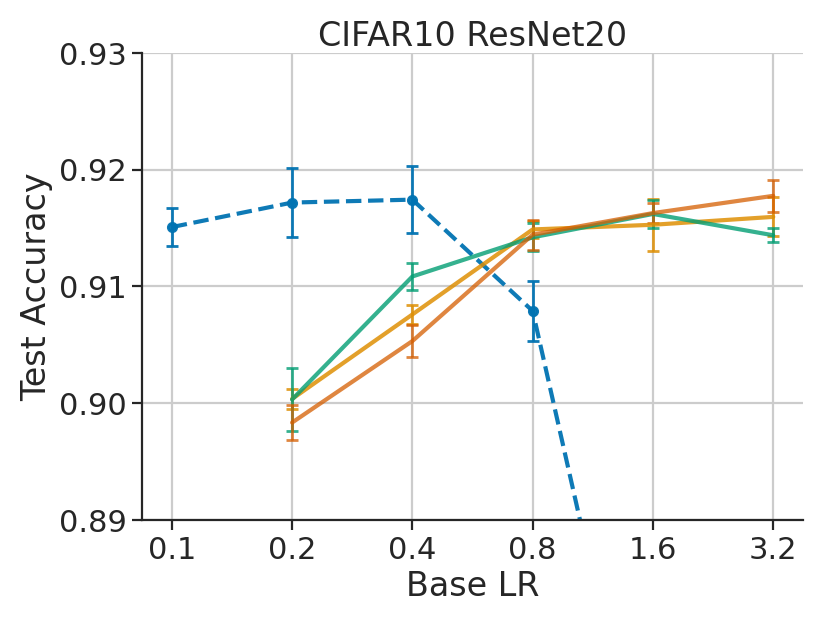

In [54]:
fig, axes = plt.subplots(dpi=200)
ls = []
ax = axes
x, ys = np.array(lrs_bs128), accs_bs128
ym, ye = ys.mean(0), ys.std(0)
l = ax.errorbar(np.log2(x*10), ym, yerr=ye, elinewidth=1, capsize=2, ls='--', marker='.', alpha=0.95)
ls.append(l)
for w, warmup in enumerate(warmups):
    if w in [0, 1]:
        continue
    x, ys = np.array(lrs_bs1024), accs_wl[w].T
    ym, ye = ys.mean(0), ys.std(0)
    l = plt.errorbar(np.log2(x*10), ym, yerr=ye, elinewidth=1, capsize=2, alpha=0.95-0.05*w)
    ls.append(l)
plt.xticks([0, 1, 2, 3, 4, 5], [0.1, 0.2, 0.4, 0.8, 1.6, 3.2])
plt.ylim(0.89, 0.93)
plt.xlabel("Base LR")
plt.ylabel("Test Accuracy")
plt.title("CIFAR10 ResNet20")
plt.show()

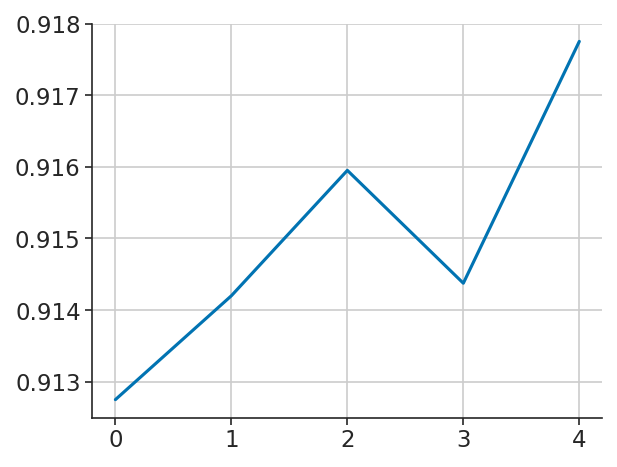

In [60]:
plt.plot(accs_wl[:,-1].mean(-1))